# Challenge

This challenge is designed to increase difficulty gradually. First, we will start by gaining some intuition about the different steps of the problem by looking at different circuits and topologies of 5-qubit chips. As the final part of the challenge, we will guide you to design your own routing algorithm.

### Cell for installing necessary packages:

In [ ]:
# Uncomment to install the necessary packages
# !pip install numpy
# !pip install scipy
# !pip install matplotlib
# !pip install jupyter
# !pip install qiskit[visualization]==1.2
# # For Local Linux or Mac, you can use the following command:
# # !pip install 'qiskit[visualization]'==1.2
# !pip install qiskit_algorithms
# !pip install qiskit_aer >= 0.14
# !pip install qiskit_ibm_runtime
# !pip install qiskit_ibm_transpiler

### Some helper functions, for plotting:

In [2]:
from matplotlib.pyplot import figure
from qiskit import QuantumCircuit


def plotting_circuit_with_title(circuit: QuantumCircuit, title: str):
    """Plots the given Quantum Circuit, with the passed title.

    Args:
        circuit (QuantumCircuit): The quantum circuit to plot together with its title.
        title (str): Title of the plot.
    """
    ax = figure().add_subplot()
    ax.set_title(title)
    circuit.draw(output="mpl", ax=ax)

    return ax


def adding_timeslices_to_circuit_plot(circuit: QuantumCircuit, title: str, timeslices: list[float]):
    """This function adds vertical lines to the circuit plot to divide the circuit into time slices.

    Args:
        circuit (QuantumCircuit): The quantum circuit to plot together with the time slices.
        timeslices (list): A list of floats representing the horizonal positions of the time slices to plot.
    """

    ax = plotting_circuit_with_title(circuit, title)

    # divide the circuit into time slices
    for x in timeslices:
        ax.axvline(x, color="red", linestyle="--")


## Warm up - GHZ state on star topology

If we have access to a 5-qubit digital chip with a star topology (FIG.1). In this topology, all two-qubit gates need to be implemented using the central qubit as a mediator. You can start by considering that the central qubit is bidireccional, i.e., it can be used as a control or target qubit. 

<p style="text-align: center"><img src="https://i.imgur.com/tVLBLaG.png" width=400 /></p>

*FIG.1: Star topology with 5 qubits.*

As a first step, we will generate a state of particular importance for quantum computation and physics, the Greenberger–Horne–Zeilinger (GHZ) state.   The GHZ state is a maximally entangled state, meaning that the qubits are highly correlated with each other and therefore, any measurement on one qubit will instantaneously affect the state of the other qubits. The GHZ state is a superposition of all qubits being in the state $|0\rangle$ and all qubits being in the state $|1\rangle$ and it is generated by the following circuit (FIG.2).

## IMPORTS:

In [3]:
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit

<Axes: title={'center': 'GHZ state preparation circuit'}>

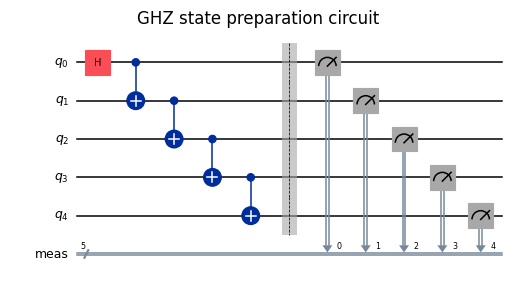

In [4]:
ghz_c = QuantumCircuit(5)

ghz_c.h(0)
ghz_c.cx(0, 1)
ghz_c.cx(1, 2)
ghz_c.cx(2, 3)
ghz_c.cx(3, 4)

ghz_c.measure_all()

plotting_circuit_with_title(ghz_c, "GHZ state preparation circuit")

In [5]:
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import SamplerV2 as Sampler

# Execute the circuit with the default initial state |00000>.

# Set up the Estimator
estimator = Sampler(mode=AerSimulator())

# Submit the circuit to Estimator
job = estimator.run(pubs=[ghz_c])

# get the results
result = job.result()[0]

# interpret the results as a "counts" dictionary
result.data.meas.get_counts()

{'11111': 519, '00000': 505}

### Question
Considering a the star topology of FIG.1, can you implement the GHZ preparation circuit with the necessary SWAPS to implement it?

> Notice: that the first swap, can be implemented as a initial layout, without error.
> Notice: that the final mapping ends up different, than the chosen initial layout.


<Axes: title={'center': 'GHZ state preparation circuit, topology embedded'}>

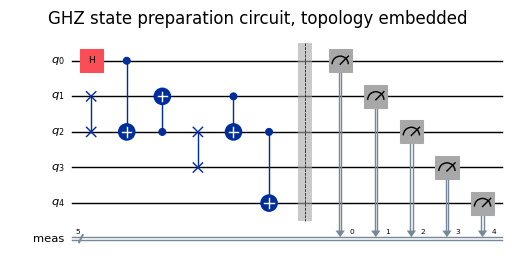

In [6]:
ghz_routed_c = QuantumCircuit(5)

ghz_routed_c.swap(1, 2)
ghz_routed_c.h(0)
ghz_routed_c.cx(0, 2)
ghz_routed_c.cx(2, 1)

ghz_routed_c.swap(2, 3)
ghz_routed_c.cx(1, 2)
ghz_routed_c.cx(2, 4)

ghz_routed_c.measure_all()

ghz_routed_layout = {}  # Add the used initial layout

print("> Notice: that the first swap, can be implemented as a initial layout, without error.")
print("> Notice: that the final mapping ends up different, than the chosen initial layout.")
plotting_circuit_with_title(ghz_routed_c, "GHZ state preparation circuit, topology embedded")

## Exercise 1

Now consider the circuit from FIG.2. Your mission is to implement this circuit in the star topology by following the steps below:


Depth of circuit:  <bound method QuantumCircuit.depth of <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x1574fabe0>>


<Axes: title={'center': 'FIG. 2: Given circuit'}>

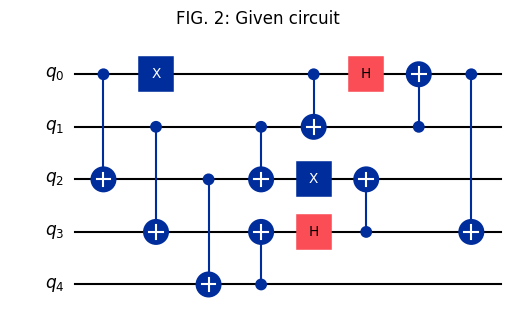

In [6]:
c = QuantumCircuit(5)
c.cx(0, 2)
c.cx(2, 4)
c.cx(1, 3)
c.x(0)
c.cx(4, 3)
c.cx(1, 2)
c.cx(0, 1)
c.x(2)
c.h(0)
c.h(3)
c.cx(1, 0)
c.cx(3, 2)
c.cx(0, 3)

print("Depth of circuit: ", c.depth)
plotting_circuit_with_title(c, "FIG. 2: Given circuit")


### 1.1. Divide the circuit into timeslices.

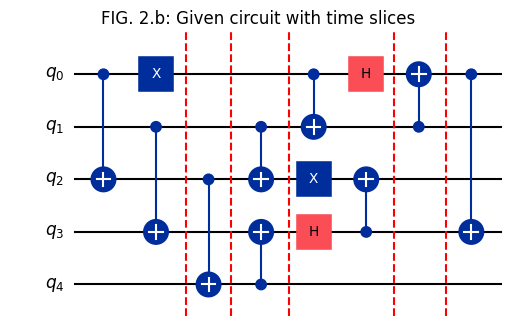

In [7]:
# Divide the circuit into time slices
timeslices = [1.35, 2.2, 3.3, 5.3, 6.3]

adding_timeslices_to_circuit_plot(c, "FIG. 2.b: Given circuit with time slices", timeslices)

### 1.2. Determine the initial placement of the qubits such that the maximum number of two-qubit gates can be implemented without SWAPS. This may not be trivial to see so you can always try a random placement, the only problem is that you will have to implement more SWAPS, which is the metric we want to minimize throughout the challenge.

Answer 2. Trivial mapping seems optimal

In [8]:
c_optimal_layout = {"q0": 0, "q1": 1, "q2": 2, "q3": 3, "q4": 4}


### 1.3. Once the initial placement is defined, how many extra SWAPS do you need to implement the circuit? 


Answer 3. 2 SWAPS are required later on, with a kind of smart diagonal SWAP, from q2 to q3, we obtain the next circuit:

Depth of circuit:  <bound method QuantumCircuit.depth of <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x1576fb760>>


<Axes: title={'center': 'FIG 2.c: Given circuit, routed to the star topology.'}>

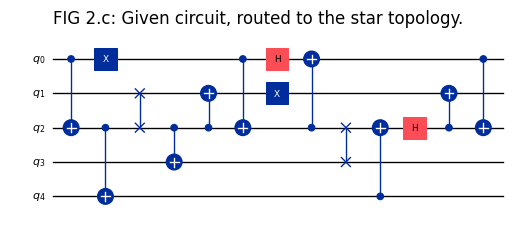

In [9]:
routed_c = QuantumCircuit(5)
routed_c.cx(0, 2)
routed_c.cx(2, 4)
routed_c.swap(1, 2)
routed_c.cx(2, 3)
routed_c.x(0)
routed_c.cx(2, 1)
routed_c.cx(0, 2)
routed_c.x(1)
routed_c.h(0)
routed_c.cx(2, 0)

# Notice, I've moved the (4,3) gate, all the way here, until the next 3 or 4 qubit dependencies.
# So I can now change the 3 by 2, and solve all the remaining 3 qubit dependencies (which were all):
routed_c.swap(3, 2)
routed_c.cx(4, 2)
routed_c.h(2)
routed_c.cx(2, 1)
routed_c.cx(0, 2)

print("Depth of circuit: ", routed_c.depth)
plotting_circuit_with_title(routed_c, "FIG 2.c: Given circuit, routed to the star topology.")


### 1.4. Now imagine that the central qubit is unidirectional (the case of real quantum hardware), i.e., it can only be used as a control qubit. How much does the depth of the circuit increase in this case?

Answer 4. If qubit 2, can only interact as control, then our circuit becomes:

In [ ]:
# Use the previous functions from the `Intro.ipynb`` notebook!

directional_c = QuantumCircuit(5)

# First direction change
# add_reversed_CNOT_in_correct_order(directional_c, 2, 0)

# directional_c.add(gates.CNOT(2, 4))

# # First SWAP into CNOT with correct direction:
# add_SWAP_as_directional_CNOTs(directional_c, 2, 1)

# directional_c.add(gates.CNOT(2, 3))
# directional_c.add(gates.X(0))
# directional_c.add(gates.CNOT(2, 1))

# # Second direction change
# add_reversed_CNOT_in_correct_order(directional_c, 2, 0)

# directional_c.add(gates.X(1))
# directional_c.add(gates.H(0))
# directional_c.add(gates.CNOT(2, 0))

# # Second SWAP into CNOT with correct direction:
# add_SWAP_as_directional_CNOTs(directional_c, 2, 3)

# # Third direction change
# add_reversed_CNOT_in_correct_order(directional_c, 2, 4)

# directional_c.add(gates.H(2))
# directional_c.add(gates.CNOT(2, 1))

# # Last direction change
# add_reversed_CNOT_in_correct_order(directional_c, 2, 0)


print("Depth of circuit: ", directional_c.depth)
plotting_circuit_with_title(
    directional_c, "FIG 2.d: Given circuit, routed to the star topology, with directional CNOTs."
)

### 1.5. Is there any trivial gate cancellation that can be done to reduce the depth of the circuit? (i.e. two CNOTs in sequence are just the identity. Same with two contiguous Hadamards).

5. But of course, this can be optimized, with the suggested cancelations (HH=I), where from visual inspection, we see we can at least cancel 3 pairs of H's..., and reducing the depth by 3, to 30! (everypair, also has some one qubit gate under it, making it only reduce 1 depth, and not 2... sadly)

In [ ]:
optimized_c = QuantumCircuit(5)

print("Depth of circuit: ", optimized_c.depth)
plotting_circuit_with_title(optimized_c, "FIG 2.e: Given circuit, optimized for the given directional topology.")


### 1.6. Give a method to verify that your resulting circuit represents the same unitary as the original one, i.e. both circuits are equivalent.

6. To show that the circuits are the same, we are gonna compare the distance between their final unitary matrices!

In [12]:
import numpy as np

from copy import deepcopy


def circuits_equivalence_fidelity(og_circuit, transp_circuit, layout):
    """Check if two circuits are equivalent.

    Args:
        og_circuit (QuantumCircuit): Original circuit to compare.
        transp_circuit (QuantumCircuit): Transpiler circuit to compare.
        layout (dict): Layout used for the transpiled circuit.

    Returns:
        float: Fidelity between the two circuits.
    """

    # Your code goes here
    #
    #

    return fidelity

### Testing circuit equivalence fidelity, with previous notebooks:

In [ ]:
circuits_equivalence_fidelity(ghz_c, ghz_routed_c, ghz_routed_layout)

In [ ]:
circuits_equivalence_fidelity(c, optimized_c, c_optimal_layout)

## Exercise 2

Until now, we have been using only the Star topology:

In [76]:
star_coupling_map = [[0, 2], [1, 2], [2, 3], [2, 4]]

Consider now the following topologies for a 5-qubit chip: the T-topology (FIG.3) and the chain topology (FIG.4). Follow the previous steps and compare the number of SWAPS needed to implement the circuit from FIG.2 in these two topologies. What conclusions can you draw from this comparison?

<p style="text-align: center"><img src="https://i.imgur.com/6SeZYmO.png" width=400 /></p>


*FIG.3: T-topology with 5 qubits*

In [77]:
# You won't need to use them now, since this exercise is manual, but later you will.
T_coupling_map = [[0, 2], [1, 2], [2, 3], [2, 4]]

# Your code goes here:
#
#

<p style="text-align: center"><img src="https://i.imgur.com/vKNOWlh.png" width=400 /></p>

*FIG.4: Chain topology with 5 qubits*

In [78]:
# You won't need to use them now, since this exercise is manual, but later you will.
linear_coupling_map = [...]  # Define the linear coupling map

# Your code goes here:
#
#

## Exercise 3

### Using Qiskit own layout and routing [Transpiler Passes](https://docs.quantum.ibm.com/api/qiskit/transpiler_passes) algorithms, run the previous circuits and compare it with your results.

(To understand better, how to use IBM transpilation, try `basic_intro/notebooks_with_corrections/QFF_Graded_Notebook_3.ipynb`)

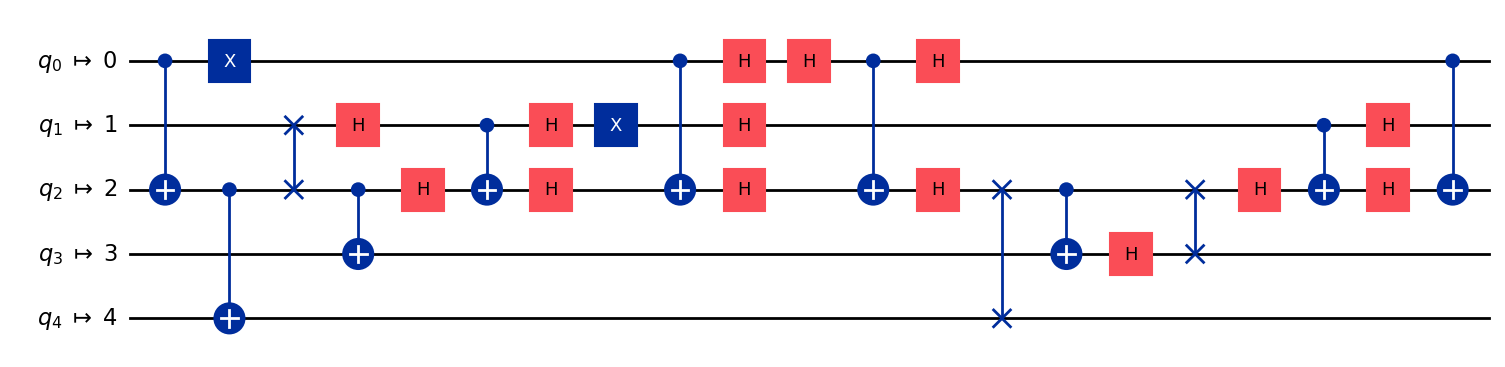

In [79]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_aer import AerSimulator

simulator = AerSimulator()

star_transpiler_lv0 = generate_preset_pass_manager(
    backend=simulator, coupling_map=star_coupling_map, optimization_level=0, seed_transpiler=1234
)

transpiled_c_lv1 = star_transpiler_lv0.run(c)
transpiled_c_lv1.draw(output="mpl")

### Run at least 4 or 6 different combinations of Topologies, Layout and Routing Passes, from the offered by Qiskit:

For example, try:
- The default IBM settings, like above, with different `optimization_levels`
   
   (can you guess/find, which Layout and Routing passes its using?) 

- Use combinations of the `TrivialLayout`, `SabreLayout`, `DenseLayout` with the Routing Pass: `SabreSwap`.

- Choose some other Routing Pass aswell, like: `BasicSwap`, `LookaheadSwap`, etc.. with the Layout pass that you liked the most.

#### Default IBMs, with different optimizations:

In [80]:
# Your code goes here:
#
#

#### SABRE Routing with different combinations of Layouts:

In [81]:
sabre_star_transpiler_lvl1 = generate_preset_pass_manager(
    backend=simulator,
    coupling_map=star_coupling_map,
    layout_method="sabre",
    routing_method="sabre",
    optimization_level=1,
    seed_transpiler=1234,
)

# Your code goes here:
#
#

#### Change the Routing Pass, with the Layout you liked the most:

In [82]:
# Your code goes here:
#
#

#### Now with another topology:

In [ ]:
T_transpiler_lv1 = generate_preset_pass_manager(
    backend=simulator, coupling_map=T_coupling_map, optimization_level=1, seed_transpiler=1234
)

linear_transpiler_lv1 = generate_preset_pass_manager(
    backend=simulator, coupling_map=linear_coupling_map, optimization_level=1, seed_transpiler=1234
)

# Your code goes here:
#
#

### Since we see, that depending on the executions, we get different number of SWAP gates...
### Do an iterator, that tries several times, and keeps the best result:

In [14]:
def find_best_routing(circuit: QuantumCircuit, optimization_level: int, coupling_map: list, iterations=10):
    """Iterate, through different Find the best routing for a given circuit.

    Args:
        circuit (qiskit.QuantumCircuit): Circuit to route.
        optimization_level (int): Optimization level to use.
        coupling_map (list): Coupling map of the target device.
        iterations (int): Number of iterations to run.

    Returns:
        qiskit.QuantumCircuit: Best routed circuit.
        dict: Final layout, of the chosen best circuit.
    """

    simulator = AerSimulator()

    transpiler = generate_preset_pass_manager(optimization_level, simulator, coupling_map=coupling_map)

    best_transpiled_circuit = ...
    best_layout = ...

    for _ in range(iterations):
        transpiled_c = transpiler.run(circuit)

        # Your code goes here:
        #
        #


Lets test it:

In [ ]:
coupling_map = ...
optimization_level = ...

best_transpiled_c, final_c_layout = find_best_routing(c, optimization_level, coupling_map, iterations=100)

best_transpiled_c.draw(output="mpl")
print("Transpilation Fidelity: ", circuits_equivalence_fidelity(c, best_transpiled_c, final_c_layout))

## Exercise 4 

### Implement your own, transpiler from 0, so you will appreciate, more the given tools by qiskit :)

In real hardware, we have a fixed topology and a rich variety of circuits, with different connectivies and so on. Most likely the circuit executable will not be directly mappable to the topology of the hardware. It is imperative to have a compilation procedure that, among other tasks, deals with the qubit routing. In this exercise, we will design our own algorithm for qubit routing, beware that this is not a trivial task! 

The algorithm proceeds in four stages: decomposing the input circuit into timesteps; determining an initial placement; routing across timesteps; and a final clean-up phase (optional).

We will design the qubit routing algorithm using a brand new circuit (FIG below) on the star-topology (FIG.1) but, once finished, we can test it on the circuits and topologies from the previous exercises. 

#### Check this paper, for more info on the algorithm: https://arxiv.org/pdf/2003.10611

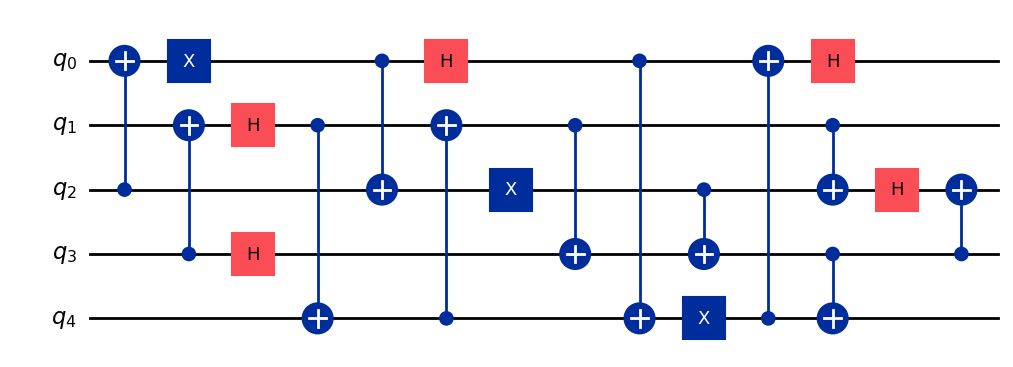

In [16]:
circuit = QuantumCircuit(5)

circuit.cx(2, 0)
circuit.cx(3, 1)
circuit.x(0)
circuit.h(1)
circuit.cx(1, 4)
circuit.cx(0, 2)
circuit.h(3)
circuit.cx(4, 1)
circuit.x(2)
circuit.cx(1, 3)
circuit.h(0)
circuit.cx(0, 4)
circuit.cx(2, 3)
circuit.x(4)
circuit.cx(4, 0)
circuit.cx(1, 2)
circuit.h(2)
circuit.h(0)
circuit.cx(3, 4)
circuit.cx(3, 2)

circuit.draw(output="mpl")

### A. Slicing the circuit into timesteps

Before routing we partition the quantum circuit into timesteps. The circuit structure provides a
natural partial ordering of the gates; thus a greedy algorithm starting from inputs can divide the input circuit into “horizontal” partitions of gates which can be executed simultaneously. We simply traverse the circuit adding the qubits involved in a 2-qubit gate to the current timestep. Since only multiqubit interactions (such as CNOT or CZ gates) constrain the problem, single qubit gates can be ignored (fMore accurately: while the single qubit gates can be ignored for the purposes of routing, they must be retained for circuit generation; for clarity we ignore them for now).

If a gate requires a qubit already used in the previous timestep, a new timestep is created. This procedure is repeated until all gates are assigned to a timestep. A timestep thus consists of a set of disjoint pairs of (virtual) qubits which represent gates scheduled for simultaneous execution.

#### Q1. Can you obtain the timesteps for the circuit of FIG.2? 

Write the timesteps in the following format: 

$$\begin{aligned}
&1 \rightarrow \{(q_i, q_j), (q_k, q_l), ...\}  \hspace{4mm} i,j,k,l \in \{0,1,2,3,4\}\\
&2 \rightarrow \{(...), ...\}\\
&3 \rightarrow \{(...),...\}\\
&4 \rightarrow \{(...),...\}\\
\end{aligned}$$

Timesteps is a list of lenght $T$ with $T$ being the total number of timesteps.  At time step $t \in [0,T-1]$, we find $L$ tuples, with $L$ being the total number of interactions. There is a tuple for each interaction between qubit $i$ and $j$, with $i\neq j$. For the circuit tutorial, you can just type it manually.

As an example, the timesteps for the tutorial circuit would be ```timesteps = [[(0,2), (1,3)], [(1,2)], [(0,1)], [(0,1), (2,3)]]```

In [366]:
timesteps = [[(...), (...)], [(...), (...)]]

 **BONUS.** To generalize the algorithm, write a ```function``` that takes as input a circuit (or a list of gates per qubit) and outputs the timesteps. Skip this step and only do it when you have completed exercises B and C. You will only need this function if you want to test random extra circuits.

In [367]:
def generate_timesteps(circuit: QuantumCircuit) -> list[list[tuple]]:
    """
    Function to determine the timesteps of a given circuit

    Args:
        circuit (Qibo circuit): qibo circuit to determine the timesteps

    Returns:
        timesteps (list): list of timesteps with the qubits involved in each timestep
    """

    # Your code goes here:
    #
    #

    return timesteps


### B. Initial Mapping

For the routing algorithm to proceed we require an initial mapping of virtual qubits (referred to as qubits) and physical qubits (referred to as nodes).

Iterate over the timesteps to construct a graph whose nodes are qubits. At timestep $n$ add the edge $(q, q')$ to the graph if *(i)* this pair is present in the timestep and *(ii)* both qubits $q$ and $q'$ have degrees (num of edged in them) less than 2 in the current graph.  If done correctly, each connected component of the resulting graph is necessarily either a line or a ring; the rings are broken by removing an arbitrarily chosen edge. 

Disconnected qubits in this graph correspond to qubits which never interact at all, or to those whose first interaction is qith a qubit whose first two interactions are with others. You can ignore these disconnected qubits as they are not needed for the initial placement, but they will be added later in the routing procedure. 

Once you have obtained this graph, select a subgraph of the architecture with high average degree and low diameter to start from. It should now be possible to map the qubit graph to the architecture as one long line starting from the a high degree vertex within this subgraph, and greedily choosing the highest degree available neighbor. This ensures that most of the gates in the first two timesteps can be applied without any SWAPS. The only exceptions are those gates corresponding to the edges removed when breaking rings. 

If the initial mapping cannot be completed as one long line, then the line is split and mapped as several line segments.
Program the ```initial_mapping``` function that takes as input the timesteps and outputs the initial mapping as a dictionary
 

In [368]:
def initial_mapping(timesteps: list) -> dict[int, int]:
    """
    Function to determine the initial mapping of the qubits to the architecture.

    Args:
        timesteps (list): list of timesteps with the qubits involved in each timestep

    Returns:
        dict: dictionary with the initial mapping of virtual qubits (referred to as qubits) to physical qubits (referred to as nodes)
    """

    # Your code goes here:
    #
    #

    return mapping


### C. Routing


The routing algorithm that we want to implement iteratively constructs a new circuit which conforms to the desired architecture, taking the sliced circuit and the current mapping of qubits to nodes as input. 

The algorithm compares the current timestep of the input circuit to the current qubit mapping. If a gate in the current timestep requires a qubit which has not yet been mapped, it is allocated to the nearest available node to its partner. All gates which can be performed in the current mapping - all 1-qubit gates and 2-qubit gates whose operands are connected - are immediately removed from the timestep and added to the output circuit. If this exhausts the current timestep, we advance to the next, otherwise SWAPs must be added. 

You will need to define a distance vector $d(s,m)$ which approximates the number of SWAPs needed to make timestep $s$ executable in the mapping $m$; these vectors need to be ordered pointwise. Let $s_0$ denote the current timestep, $s_1$ for its successor, and so on and write $\sigma \bullet m$ to indicate the action of swap $\sigma$ upon the mapping $m$. You can compute the sequence of sets of candidate SWAPs as follows:
$$\begin{aligned}
&\sum_0 = \mathrm{swaps} (s0)\\
&\sum_{t+1} = \text{argmin}_{\sigma\in\sum_t} d(s_t, \sigma \bullet m)
\end{aligned}$$
where $\mathrm{swaps}(s_0)$ denotes all the pertinent SWAPs available at the inital timestep. The sequence terminates either when $|\sum_t|=1$ or after a predefined cutoff (optional). The selected SWAP is added to the circuit and the mapping is updated accordingly. We now return to the start and continue until the entire input circuit has been consumed. 

As guiding, the pointwise of the distance employed should be strict in the sense that $d(s,m)>d(s,\sigma \bullet m)$ implies that for *all* pairs of qubits ($q,q'$) in $s$, the longest of the shortest paths between any two paired qubits in $\sigma \bullet m$ is not longer than the longest of the shortest paths in $m$. 

In other words, the diameter of the subgraph composed of all pairs of qubits ($q,q'$) in $s$ should decrease strictly under the action of $\mathrm{swap}$ $\sigma$ on the mapping $m$. However, in some highly symmetric configurations, the algorithm sometimes could get stuck, failing to find any candidate swap. 

Even though this issue is not common, we propose two possible solutions for our bravest challengers. The first strategy is to attempt the process again with pairs of disjoint swaps instead of individual ones. If this also fails, then we suggest to resort to brute force: a pair of maximally distant qubits in the current timestep are brought together using a sequence of waps along their shortest connecting path. This guarantees at least on gate may be performed, and disrupts the symmetry of the configuration. 


**REMARK**. Remember that you need to keep track of the single qubit gates in order to correctly rebuild the circuit! 

**BONUS**. In practice, there is no need to slice the circuit in advance, and in fact better results are achieved by computing timesteps dynamically during routing. The "next slice" is recomputed immediately after each update of the mapping, avoiding any unnecessary sequentialisation. If you have time, try to implement this dynamic slicing.


In [369]:
def routing(timesteps: list[list[tuple[int, int]]], initial_mapping: dict[int, int]) -> QuantumCircuit:
    """
    Function that takes as input the timesteps and the initial mapping and outputs the final circuit.

    Args:
    timesteps (List[List[Tuple[int, int]]]): A list of timesteps, where each timestep is a list of tuples representing
                                             the qubits involved in two-qubit gates at that timestep.

    initial_mapping (Dict[int, int]): A dictionary representing the initial mapping of virtual qubits (keys) to
                                      physical qubits (values).

    Returns:
    models.Circuit: A Qibo circuit object representing the final quantum circuit after applying the routing algorithm.
    """

    # Your code goes here:
    #
    #

    return routed_circuit


Once you have implemented the routing algorithm, you can test it with the topologies of Exercise 2 to see if it is works correctly!

### D. SWAP synthesis and clean-up (EXTRA)

Program a function that takes as input the final routing circuit and looks for trivial identities to be eliminated to ensure the shortest depth possible. 

In [370]:
def optimize_circuit(circuit: QuantumCircuit) -> QuantumCircuit:
    """
    Function that takes as input the circuit and outputs the optimized circuit

    Args:
        circuit (QuantumCircuit): The circuit to be optimized.

    Returns:
        QuantumCircuit: The optimized circuit.
    """

    # Your code goes here:
    #
    #

    return optimized_circuit

### TESTING EVERYTHING:

> Hint: First test each function separately (called unit-tests)

Run each function, one after the other, and check you get a good final optimized circuit!

In [381]:
circuit_timesteps = generate_timesteps(circuit)
initial_layout = initial_mapping(circuit_timesteps)
routed_circuit = routing(circuit_timesteps, initial_layout)
optimized_circuit = optimize_circuit(routed_circuit)

# Example: Add the final expected circuit to obtain
# Your code goes here:
#
#
expected_circuit = ...

assert optimized_circuit == expected_circuit

print("All tests passed")

All tests passed


## Exercise 5 (More challenging)

First, a disclaimer, finding optimal qubit routing algorithms is an open-research question. If you made it through here, let us congratulate you, it was not an easy task! 

Can you think of another algorithm, that would also work, even if it is very simple or slow? Try and implement it! 

- How does it compare with the provided?

- What 2q gates depths do you get? Try different circuits!

## Exercise 6 (Truly challenging - research level)

In case anyone loved this challenge and would like to explore a continuation, we leave to you a possible extension of this problem with machine-learning. The main idea is expressed in this [paper](https://arxiv.org/abs/1812.11619), where the authors use Reinforcement Learning to learn optimal policies for qubit routing. Good luck!